data는 R에서 전처리 된 data를 사용했으며, 모델링과 시각화 코드만 첨부되어있습니다.

# 패키지 로딩 및 패키지 로딩

In [2]:
!pip install shap

     |████████████████████████████████| 564 kB 20.3 MB/s 


In [3]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import percentileofscore

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import make_scorer, roc_curve, roc_auc_score, auc
from sklearn.model_selection import cross_validate, cross_val_score, GridSearchCV
from scipy import interp

import shap

In [4]:
# 코랩용 데이터 불러오기 
from google.colab import files
myfile = files.upload()

import io
import pandas as pd

Saving dat_tes.csv to dat_tes.csv
Saving dat_tra.csv to dat_tra.csv


In [5]:
# 코랩용 데이터 불러오기
dat_tra = pd.read_csv(io.BytesIO(myfile['dat_tra.csv']))
dat_tes = pd.read_csv(io.BytesIO(myfile['dat_tes.csv']))

In [ ]:
# 주피터 노트북용 데이터 불러오기
# dat_tra = pd.read_csv('dat_tra.csv')
# dat_tes = pd.read_csv('dat_tes.csv')

In [6]:
# 이름 변경 딕셔너리
name_dic = {'age_w0':'Age',
            'sex':'Sex (female)',
            'firstSickAge_w0':'First sick age',
            'duration_illness':'Duration of illness',
            'educationFlag_w0':'Education',
            'occupationFlag_w0':'Occupation (employed)',
            'CGISCHSO_w0':'CGI Overall',
            'CGISCHSP_w0':'CGI Positive',
            'CGISCHSN_w0':'CGI Negative',
            'CGISCHSD_w0':'CGI Depressive',
            'CGISCHSC_w0':'CGI Cognitive',
            'scl_som_sum':'SCL Somatization',
            'scl_oc_sum':'SCL Obsessions-compulsions',
            'scl_is_sum':'SCL Interpersonal sensitivity',
            'scl_dep_sum':'SCL Depression',
            'scl_anx_sum':'SCL Anxiety',
            'scl_hos_sum':'SCL Hostility',
            'scl_phob_sum':'SCL Phobic anxiety',
            'scl_par_sum':'SCL Paranoid ideation',
            'scl_psy_sum':'SCL Psychoticism',
            'PSPA_w0':'PSP A',
            'PSPB_w0':'PSP B',
            'PSPC_w0':'PSP C',
            'PSPD_w0':'PSP D',
            'PSPscore_w0':'PSP total score',
            'w0_DAI_total':'DAI total',
            'DIEPSS_OverallSeverity_w0':'DIEPSS overall severity',
            'meta_syn_gr':'Metabolic syndrome (yes)',
            'bmi':'BMI',
            'w0_Prolactin':'Prolactin'
            }

## 필요한 함수 생성

In [7]:
# auc score의 confidence interval을 구하는 함수

def score_ci(y_true, y_pred, score_fun, sample_weight=None, n_bootstraps=2000, confidence_level=0.95, seed=None, reject_one_class_samples=True):

    assert len(y_true) == len(y_pred)

    score = score_fun(y_true, y_pred)
    _, ci_lower, ci_upper, scores = score_stat_ci(
        y_true=y_true,
        y_preds=y_pred,
        score_fun=score_fun,
        sample_weight=sample_weight,
        n_bootstraps=n_bootstraps,
        confidence_level=confidence_level,
        seed=seed,
        reject_one_class_samples=reject_one_class_samples,
    )

    return score, ci_lower, ci_upper, scores


def score_stat_ci(y_true, y_preds, score_fun, stat_fun=np.mean, sample_weight=None, n_bootstraps=2000, confidence_level=0.95, seed=None, reject_one_class_samples=True):

    y_true = np.array(y_true)
    y_preds = np.atleast_2d(y_preds)
    assert all(len(y_true) == len(y) for y in y_preds)

    np.random.seed(seed)
    scores = []
    for i in range(n_bootstraps):
        readers = np.random.randint(0, len(y_preds), len(y_preds))
        indices = np.random.randint(0, len(y_true), len(y_true))
        if reject_one_class_samples and len(np.unique(y_true[indices])) < 2:
            continue
        reader_scores = []
        for r in readers:
            if sample_weight is not None:
                reader_scores.append(score_fun(y_true[indices], y_preds[r][indices], sample_weight=sample_weight[indices]))
            else:
                reader_scores.append(score_fun(y_true[indices], y_preds[r][indices]))
        scores.append(stat_fun(reader_scores))

    mean_score = np.mean(scores)
    sorted_scores = np.array(sorted(scores))
    alpha = (1.0 - confidence_level) / 2.0
    ci_lower = sorted_scores[int(round(alpha * len(sorted_scores)))]
    ci_upper = sorted_scores[int(round((1.0 - alpha) * len(sorted_scores)))]
    return mean_score, ci_lower, ci_upper, scores

In [8]:
# 모델 별 auc socre, confidence interval를 데이터프레임 형태로 정리하는 함수

def auc_table(y_test,X_test) :

    lr_auc4 = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
    rf_auc4 = roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])
    gbm_auc4 = roc_auc_score(y_test, gbm.predict_proba(X_test)[:,1])
    xgb_auc4 = roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1])
    svc_auc4 = roc_auc_score(y_test, svc.predict_proba(X_test)[:,1])

    score, lr_lower4, lr_upper4, scores = score_ci(y_test, lr.predict_proba(X_test)[:,1], score_fun=roc_auc_score)
    score, rf_lower4, rf_upper4, scores = score_ci(y_test, rf.predict_proba(X_test)[:,1], score_fun=roc_auc_score)
    score, gbm_lower4, gbm_upper4, scores = score_ci(y_test, gbm.predict_proba(X_test)[:,1], score_fun=roc_auc_score)
    score, xgb_lower4, xgb_upper4, scores = score_ci(y_test, xgb.predict_proba(X_test)[:,1], score_fun=roc_auc_score)
    score, svc_lower4, svc_upper4, scores = score_ci(y_test, svc.predict_proba(X_test)[:,1], score_fun=roc_auc_score)   


    model_list = ['logistic regression','random forest','gbm','xgboost','scv rbf']
    model_auc4 = [lr_auc4,rf_auc4,gbm_auc4,xgb_auc4, svc_auc4]
    model_lower4 = [lr_lower4,rf_lower4,gbm_lower4,xgb_lower4,svc_lower4]
    model_upper4 = [lr_upper4,rf_upper4,gbm_upper4,xgb_upper4,svc_upper4]
    week4_auc = pd.DataFrame({'model list': model_list,'auc' : model_auc4,'lower' : model_lower4,'upper' : model_upper4})

    week4_auc = week4_auc.round(3)

    week4_auc.auc = week4_auc.auc.apply(str)
    week4_auc.upper = week4_auc.upper.apply(str)
    week4_auc.lower = week4_auc.lower.apply(str)

    return week4_auc

In [9]:
# 모델 별 roc curve를 그리는 함수

# svm 포함
def plot_roc_curve(fpers, tpers,auc,week): 

    plt.figure(figsize=(6,6))
    plt.plot(fpers[0], tpers[0], color='red', label='LR :'+ auc.loc[0,'auc']+"(" + auc.loc[0,'lower']+"," + auc.loc[0,'upper'] + ")")  # lr
    plt.plot(fpers[1], tpers[1], color='green', label='RF :'+ auc.loc[1,'auc']+"(" + auc.loc[1,'lower']+"," + auc.loc[1,'upper'] + ")") # rf
    plt.plot(fpers[2], tpers[2], color='blue', label='GBM :'+auc.loc[2,'auc']+"(" + auc.loc[2,'lower']+"," + auc.loc[2,'upper'] + ")") # gbm
    plt.plot(fpers[3], tpers[3], color='orange', label='XGB :'+ auc.loc[3,'auc']+"(" + auc.loc[3,'lower']+"," + auc.loc[3,'upper'] + ")") # xgb
    plt.plot(fpers[4], tpers[4], color='black', label='SVM :'+auc.loc[4,'auc']+"(" + auc.loc[4,'lower']+"," + auc.loc[4,'upper'] + ")") # svc

    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve Week' + str(week))
    plt.legend(loc='lower right',title = "AUC (95%CI)")
    plt.show()

# svm 미포함
def plot_roc_curve2(fpers, tpers,auc,week): 

    plt.figure(figsize=(6,6))
    plt.plot(fpers[0], tpers[0], color='red', label='LR :'+ auc.loc[0,'auc']+"(" + auc.loc[0,'lower']+"," + auc.loc[0,'upper'] + ")")  # lr
    plt.plot(fpers[1], tpers[1], color='green', label='RF :'+ auc.loc[1,'auc']+"(" + auc.loc[1,'lower']+"," + auc.loc[1,'upper'] + ")") # rf
    plt.plot(fpers[2], tpers[2], color='blue', label='GBM :'+auc.loc[2,'auc']+"(" + auc.loc[2,'lower']+"," + auc.loc[2,'upper'] + ")") # gbm
    plt.plot(fpers[3], tpers[3], color='orange', label='XGB :'+ auc.loc[3,'auc']+"(" + auc.loc[3,'lower']+"," + auc.loc[3,'upper'] + ")") # xgb

    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve Week' + str(week))
    plt.legend(loc='lower right',title = "AUC (95%CI)")
    plt.show()

In [10]:
# SHAP value 그래프를 그리는 함수

def show_shap(model_name, model, X, is_tree=False,xgbm=False):

    if is_tree == False:
      explainer = shap.KernelExplainer(model,X)

    else:
      explainer = shap.TreeExplainer(model)

    shap_values = explainer.shap_values(X)

    if xgbm == False:
        values = shap_values[1]

    else:
        values = shap_values

    shap.summary_plot(values, X, plot_type='dot',show= False, plot_size=[6,6])
    plt.title(model_name + " SHAP values ")
    plt.show()

    shap.summary_plot(values, X, plot_type = "bar",show= False, plot_size=[6,6])
    plt.title(model_name + " MEAN of SHAP values")
    plt.show()

In [11]:
# feature importance 그래프를 그리는 함수

def feature_importances(model_name, importance, names):
    importance, names = zip(*sorted(zip(importance, names)))
    plt.figure(figsize=(6,6))
    plt.barh(range(len(names)), importance, align='center')
    plt.yticks(range(len(names)), names)
    plt.title(model_name+" feature importances ")
    plt.show()

# 4주차 모델링

## 사용 변수만 불러오기

In [74]:
# 4주차에 해당하는 변수만 가지고 오기

dat_tra4 =  dat_tra[['cgis_r_w4', 'CGISCHSO_w0', 'bmi', 'w0_DAI_total', 
                      'PSPD_w0', 'PSPB_w0', 'DIEPSS_OverallSeverity_w0', 'PSPC_w0', 
                      'scl_hos_sum', 'duration_illness','occupationFlag_w0']]


dat_tes4 =  dat_tes[['cgis_r_w4', 'CGISCHSO_w0', 'bmi', 'w0_DAI_total', 
                      'PSPD_w0', 'PSPB_w0', 'DIEPSS_OverallSeverity_w0', 'PSPC_w0', 
                      'scl_hos_sum', 'duration_illness','occupationFlag_w0']]

In [75]:
dat_tra4.rename(columns = name_dic,inplace=True)
dat_tes4.rename(columns = name_dic,inplace=True)

In [76]:
X = dat_tra4.drop(columns = 'cgis_r_w4') # 설명변수만
y = dat_tra4['cgis_r_w4'] # response varaible
X_test = dat_tes4.drop(columns='cgis_r_w4')
y_test = dat_tes4['cgis_r_w4']

## 모델링

In [ ]:
# lr
parameters = {'C':[0.001, 0.01, 0.1, 1]}

lr = LogisticRegression(penalty='none', random_state=2022)  
grid = GridSearchCV(lr, parameters, cv=5, scoring = 'roc_auc')
grid.fit(X, y)
lr = grid.best_estimator_
lr.fit(X, y)

LogisticRegression(C=0.001, penalty='none', random_state=2022)

In [ ]:
# rf
parameters = {'max_depth': [5, 7, 9, 11],
                'max_features': ['auto', 'sqrt'],
                'min_samples_leaf': [2, 3, 4, 5],
                'min_samples_split': [2, 4, 6, 8],
                'n_estimators': [100, 200, 500]}

rnd = RandomForestClassifier(random_state=2022)
grid = GridSearchCV(rnd, parameters, cv=5,scoring = 'roc_auc')
grid.fit(X, y)
rf = grid.best_estimator_
rf.fit(X, y)

RandomForestClassifier(max_depth=5, min_samples_leaf=3, min_samples_split=8,
                       n_estimators=500, random_state=2022)

In [ ]:
# svc
parameters = {'C': [0.1, 1, 10],
                'gamma': [1, 0.1, 0.01, 0.001]}

svc = SVC(kernel='rbf', random_state=2022, probability=True)
grid = GridSearchCV(svc, parameters,cv=5,scoring = 'roc_auc')
grid.fit(X, y)
svc = grid.best_estimator_
svc.fit(X, y)

SVC(C=0.1, gamma=0.001, probability=True, random_state=2022)

In [ ]:
# gbm
parameters = {'max_depth': [5, 7 ,9, 11],
                'min_samples_leaf': [2, 3, 4, 5],
                'min_samples_split': [2, 4, 6],
                'n_estimators': [100, 200, 500],
                'learning_rate': [0.01, 0.05, 0.1]}

gbm = GradientBoostingClassifier(random_state=2022)
grid = GridSearchCV(gbm, parameters, cv=5,scoring = 'roc_auc')
grid.fit(X, y)
gbm = grid.best_estimator_
gbm.fit(X, y)

GradientBoostingClassifier(learning_rate=0.01, max_depth=5, min_samples_leaf=2,
                           min_samples_split=6, random_state=2022)

In [ ]:
# xgb
parameters = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'max_depth': [5, 7, 9, 11],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8],
        'learning_rate' : [0.01, 0.1],
        'n_estimators' : [100, 200, 500]
        }

xgb = XGBClassifier(silent=True, nthread=1,random_state=2022)
grid = GridSearchCV(xgb, parameters, cv=5,scoring = 'roc_auc')
grid.fit(X, y)
xgb = grid.best_estimator_
xgb.fit(X, y)

XGBClassifier(colsample_bytree=0.8, gamma=5, max_depth=7, min_child_weight=5,
              n_estimators=200, nthread=1, random_state=2022, silent=True,
              subsample=0.6)

## 결과

### 1. AUC score (test data)

In [21]:
week4_auc = auc_table(y_test,X_test)
week4_auc

,model list,auc,lower,upper
0,logistic regression,0.632,0.561,0.704
1,random forest,0.732,0.661,0.795
2,gbm,0.693,0.617,0.767
3,xgboost,0.724,0.662,0.786
4,scv rbf,0.639,0.561,0.712


### 2. ROC curve (test data)

In [22]:
# fpr : False Positive Rate , tpr : True Positive Rate 
fpers4,tpers4= [],[] # 각 모델에서의  fpr,tpr을 동시에 저장 

lr_fpr4, lr_tpr4 , lr_thresholds4 = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
fpers4.append(lr_fpr4) ; tpers4.append(lr_tpr4)

rf_fpr4, rf_tpr4 , rf_thresholds4 = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
fpers4.append(rf_fpr4) ; tpers4.append(rf_tpr4)

gbm_fpr4, gbm_tpr4 , gbm_thresholds4 = roc_curve(y_test, gbm.predict_proba(X_test)[:,1])
fpers4.append(gbm_fpr4) ; tpers4.append(gbm_tpr4)

xgb_fpr4, xgb_tpr4 , xgb_thresholds4 = roc_curve(y_test, xgb.predict_proba(X_test)[:,1])
fpers4.append(xgb_fpr4) ; tpers4.append(xgb_tpr4)

svc_fpr4, svc_tpr4 , svc_thresholds4 = roc_curve(y_test, svc.predict_proba(X_test)[:,1])
fpers4.append(svc_fpr4) ; tpers4.append(svc_tpr4)

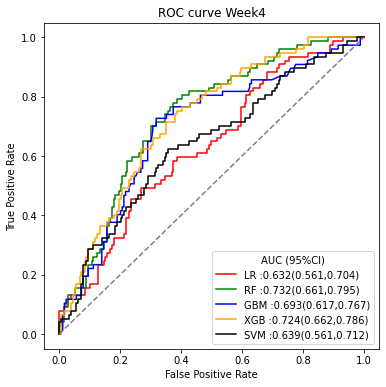

In [23]:
plot_roc_curve(fpers4, tpers4,week4_auc,4)

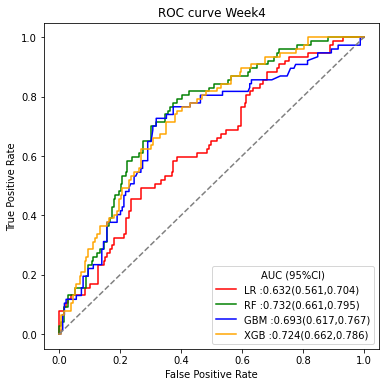

In [24]:
plot_roc_curve2(fpers4, tpers4,week4_auc,4)

### 3. SHAP value

Using 598 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/598 [00:00<?, ?it/s]

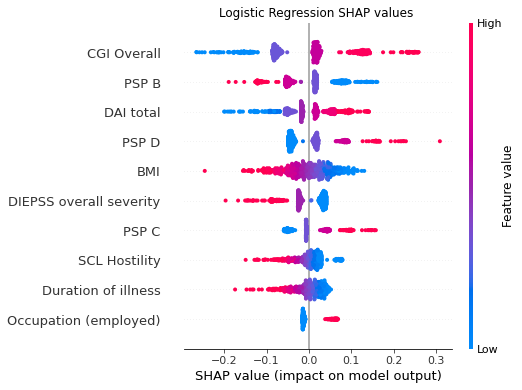

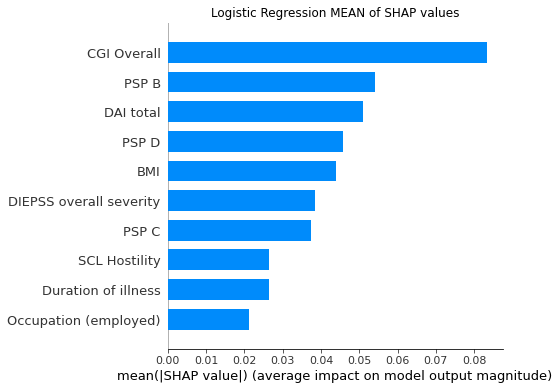

None


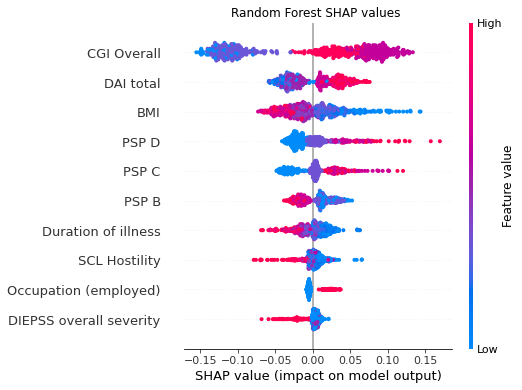

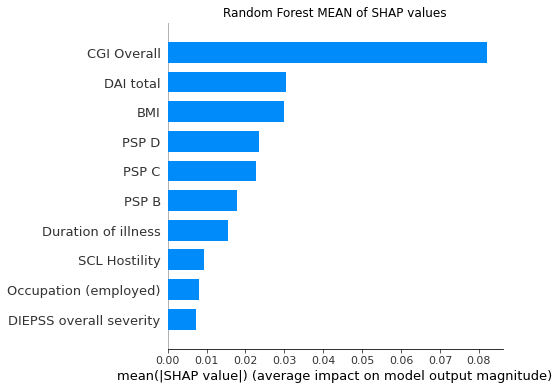

None


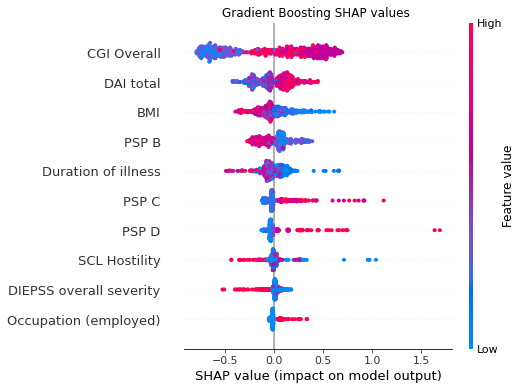

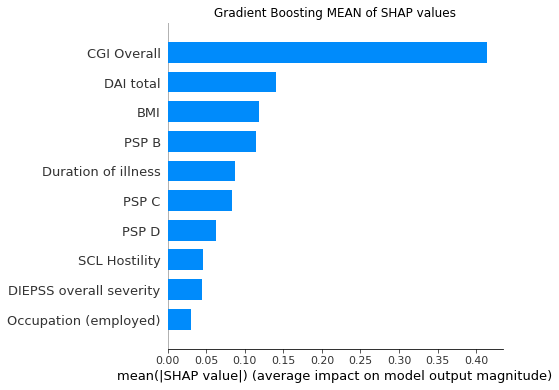

None


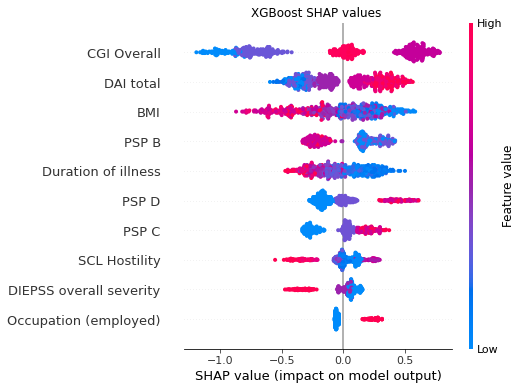

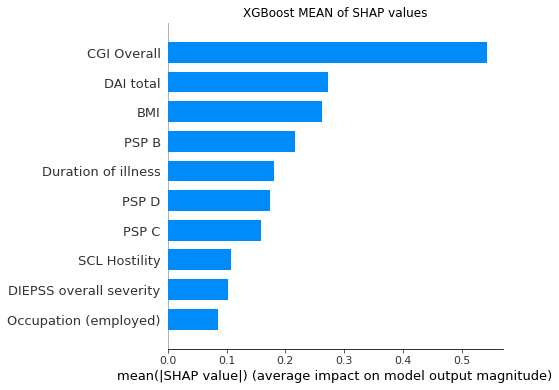

None


In [87]:
print(show_shap('Logistic Regression', lr.predict_proba, X, is_tree=False,xgbm=False))
print(show_shap('Random Forest', rf, X, is_tree=True,xgbm=False))
print(show_shap('Gradient Boosting', gbm, X, is_tree=True,xgbm=True))
print(show_shap('XGBoost', xgb, X, is_tree=True,xgbm=True))

### 4. feature importance

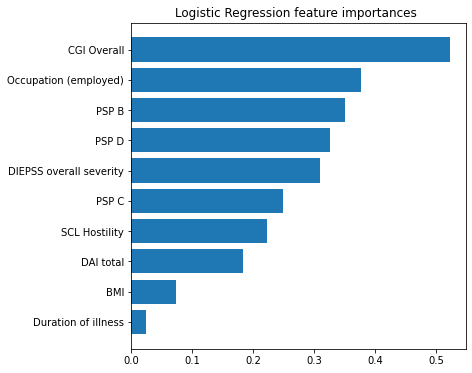

None


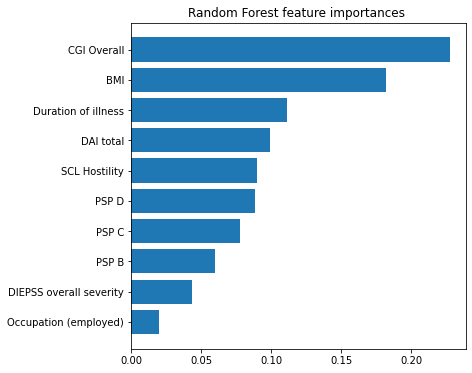

None


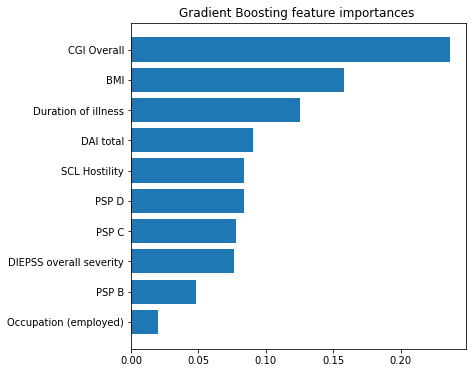

None


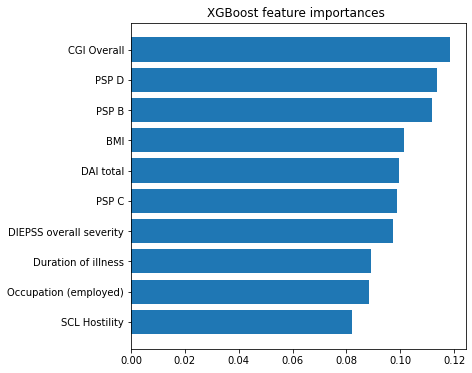

None


In [88]:
features_names = dat_tra4.columns[1:]

print(feature_importances('Logistic Regression', abs(lr.coef_[0]), features_names))
print(feature_importances('Random Forest', rf.feature_importances_, features_names))
print(feature_importances('Gradient Boosting', gbm.feature_importances_, features_names))
print(feature_importances('XGBoost', xgb.feature_importances_, features_names))

# 8주차 모델링

## 사용 변수만 불러오기

In [25]:
# 8주차에 해당하는 변수만 가지고 오기
dat_tra8 =  dat_tra[['cgis_r_w8', 'CGISCHSO_w0', 'bmi', 'CGISCHSD_w0', 
                      'w0_Prolactin', 'PSPD_w0', 'w0_DAI_total', 'DIEPSS_OverallSeverity_w0',
                      'PSPC_w0','PSPB_w0','firstSickAge_w0']]

dat_tes8 =  dat_tes[['cgis_r_w8', 'CGISCHSO_w0', 'bmi', 'CGISCHSD_w0', 
                      'w0_Prolactin', 'PSPD_w0', 'w0_DAI_total', 'DIEPSS_OverallSeverity_w0',
                      'PSPC_w0','PSPB_w0','firstSickAge_w0']]

In [26]:
dat_tra8.rename(columns = name_dic,inplace=True)
dat_tes8.rename(columns = name_dic,inplace=True)

In [27]:
X = dat_tra8.drop(columns = 'cgis_r_w8') # 설명변수만
y = dat_tra8['cgis_r_w8'] # response varaible
X_test = dat_tes8.drop(columns='cgis_r_w8')
y_test = dat_tes8['cgis_r_w8']

## 모델링

In [ ]:
# lr
parameters = {'C':[0.001, 0.01, 0.1, 1]}

lr = LogisticRegression(penalty='none', random_state=2022)  
grid = GridSearchCV(lr, parameters, cv=5, scoring = 'roc_auc')
grid.fit(X, y)
lr = grid.best_estimator_
lr.fit(X, y)

LogisticRegression(C=0.001, penalty='none', random_state=2022)

In [ ]:
# rf
parameters = {'max_depth': [5, 7, 9, 11],
                'max_features': ['auto', 'sqrt'],
                'min_samples_leaf': [2, 3, 4, 5],
                'min_samples_split': [2, 4, 6, 8],
                'n_estimators': [100, 200, 500]}

rnd = RandomForestClassifier(random_state=2022)
grid = GridSearchCV(rnd, parameters, cv=5,scoring = 'roc_auc')
grid.fit(X, y)
rf = grid.best_estimator_
rf.fit(X, y)

RandomForestClassifier(max_depth=11, min_samples_leaf=2, random_state=2022)

In [ ]:
# svc
parameters = {'C': [0.1, 1, 10],
                'gamma': [1, 0.1, 0.01, 0.001]}

svc = SVC(kernel='rbf', random_state=2022, probability=True)
grid = GridSearchCV(svc, parameters,cv=5,scoring = 'roc_auc')
grid.fit(X, y)
svc = grid.best_estimator_
svc.fit(X, y)

SVC(C=10, gamma=0.001, probability=True, random_state=2022)

In [ ]:
# gbm
parameters = {'max_depth': [5, 7 ,9, 11],
                'min_samples_leaf': [2, 3, 4, 5],
                'min_samples_split': [2, 4, 6],
                'n_estimators': [100, 200, 500],
                'learning_rate': [0.01, 0.05, 0.1]}

gbm = GradientBoostingClassifier(random_state=2022)
grid = GridSearchCV(gbm, parameters, cv=5,scoring = 'roc_auc')
grid.fit(X, y)
gbm = grid.best_estimator_
gbm.fit(X, y)

GradientBoostingClassifier(learning_rate=0.05, max_depth=9, min_samples_leaf=3,
                           random_state=2022)

In [ ]:
# xgb
parameters = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'max_depth': [5, 7, 9, 11],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8],
        'learning_rate' : [0.01, 0.1],
        'n_estimators' : [100, 200, 500]
        }

xgb = XGBClassifier(silent=True, nthread=1,random_state=2022)
grid = GridSearchCV(xgb, parameters, cv=5,scoring = 'roc_auc')
grid.fit(X, y)
xgb = grid.best_estimator_
xgb.fit(X, y)

XGBClassifier(colsample_bytree=0.8, gamma=2, max_depth=7, nthread=1,
              random_state=2022, silent=True, subsample=1.0)

## 결과

### 1. AUC score (test data)

In [33]:
week8_auc = auc_table(y_test,X_test) 
week8_auc

,model list,auc,lower,upper
0,logistic regression,0.706,0.63,0.776
1,random forest,0.785,0.729,0.842
2,gbm,0.758,0.695,0.818
3,xgboost,0.755,0.687,0.814
4,scv rbf,0.658,0.574,0.739


### 2. ROC curve (test data)

In [34]:
# fpr : False Positive Rate , tpr : True Positive Rate 
fpers8,tpers8= [],[] # 각 모델에서의  fpr,tpr을 동시에 저장 

lr_fpr8, lr_tpr8 , lr_thresholds8 = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
fpers8.append(lr_fpr8) ; tpers8.append(lr_tpr8)

rf_fpr8, rf_tpr8 , rf_thresholds8 = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
fpers8.append(rf_fpr8) ; tpers8.append(rf_tpr8)

gbm_fpr8, gbm_tpr8 , gbm_thresholds8 = roc_curve(y_test, gbm.predict_proba(X_test)[:,1])
fpers8.append(gbm_fpr8) ; tpers8.append(gbm_tpr8)

xgb_fpr8, xgb_tpr8 , xgb_thresholds8 = roc_curve(y_test, xgb.predict_proba(X_test)[:,1])
fpers8.append(xgb_fpr8) ; tpers8.append(xgb_tpr8)

svc_fpr8, svc_tpr8 , svc_thresholds8 = roc_curve(y_test, svc.predict_proba(X_test)[:,1])
fpers8.append(svc_fpr8) ; tpers8.append(svc_tpr8)

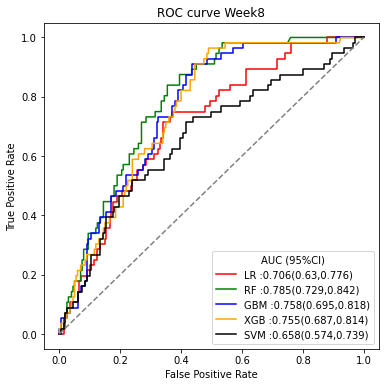

In [35]:
plot_roc_curve(fpers8, tpers8,week8_auc,8)

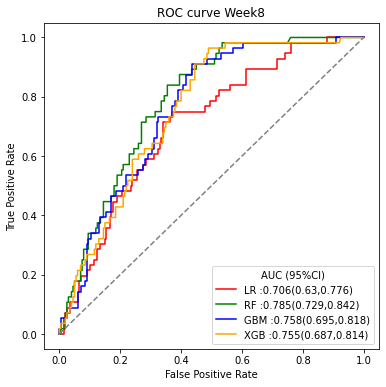

In [36]:
plot_roc_curve2(fpers8, tpers8,week8_auc,8)

### 3. SHAP value

Using 598 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/598 [00:00<?, ?it/s]

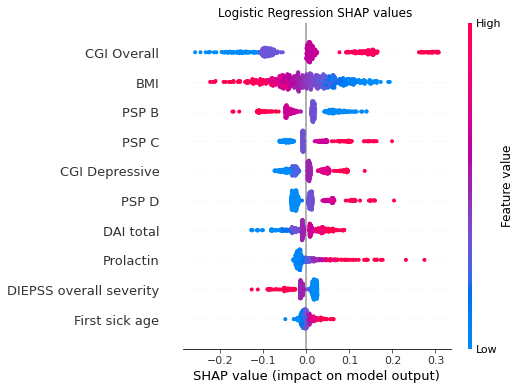

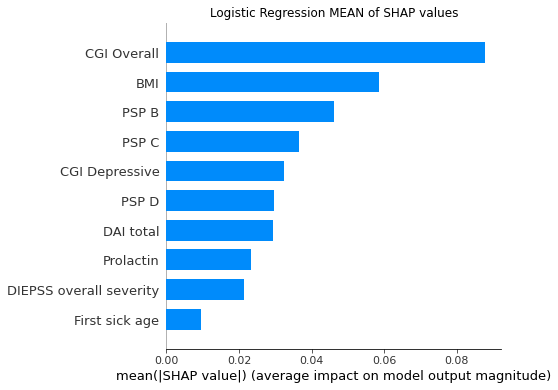

None


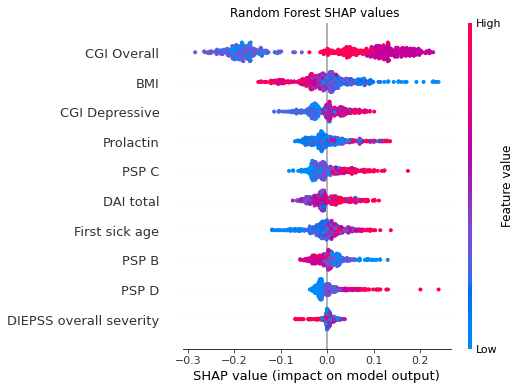

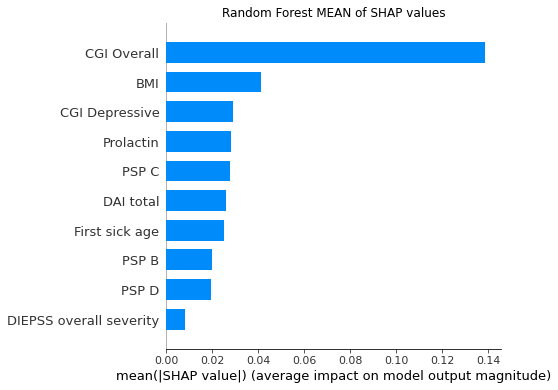

None


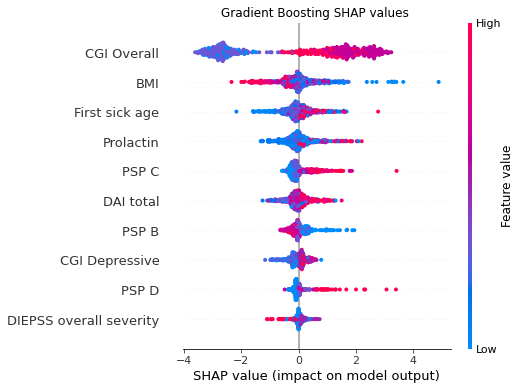

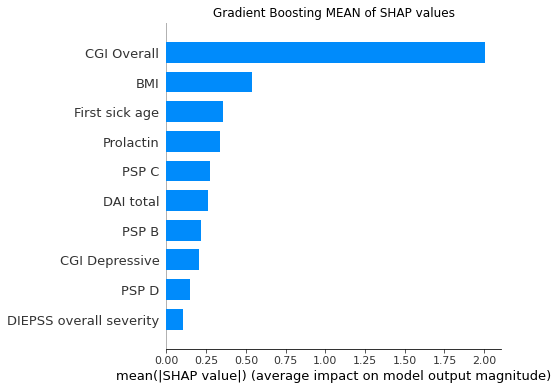

None


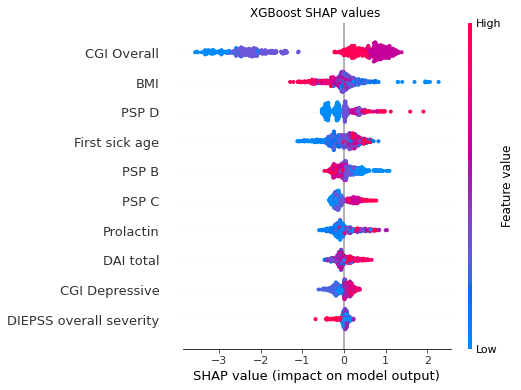

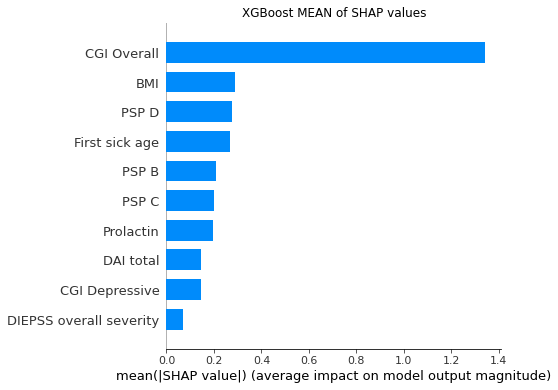

None


In [ ]:
print(show_shap('Logistic Regression', lr.predict_proba, X, is_tree=False,xgbm=False))
print(show_shap('Random Forest', rf, X, is_tree=True,xgbm=False))
print(show_shap('Gradient Boosting', gbm, X, is_tree=True,xgbm=True))
print(show_shap('XGBoost', xgb, X, is_tree=True,xgbm=True))

### 4. feature importance

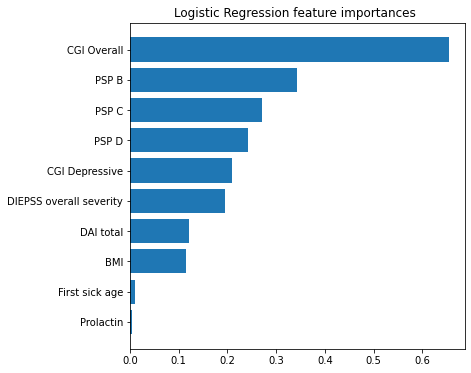

None


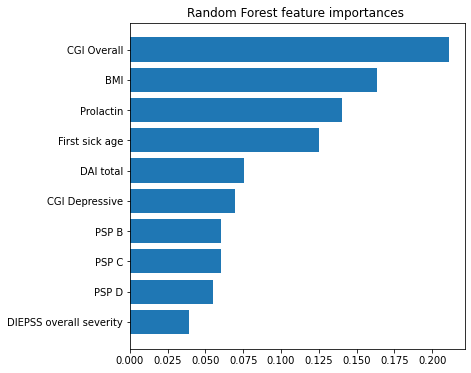

None


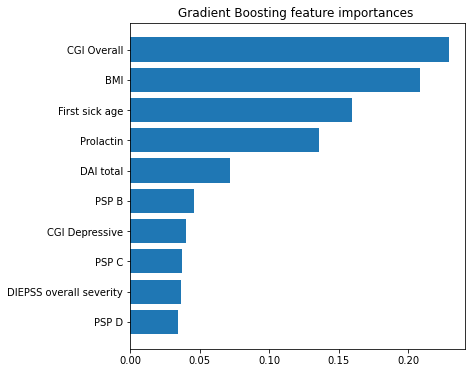

None


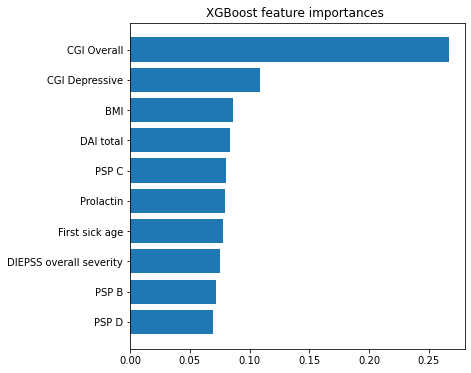

None


In [ ]:
features_names = dat_tra8.columns[1:]

print(feature_importances('Logistic Regression', abs(lr.coef_[0]), features_names))
print(feature_importances('Random Forest', rf.feature_importances_, features_names))
print(feature_importances('Gradient Boosting', gbm.feature_importances_, features_names))
print(feature_importances('XGBoost', xgb.feature_importances_, features_names))

# 12주차 모델링

## 사용 변수만 불러오기

In [37]:
# 12주차에 해당하는 변수만 가지고 오기
dat_tra12 =  dat_tra[['cgis_r_w12','CGISCHSO_w0','bmi', 'PSPD_w0', 
                    'scl_dep_sum','CGISCHSD_w0', 'duration_illness','w0_DAI_total']]

dat_tes12 =  dat_tes[['cgis_r_w12','CGISCHSO_w0','bmi', 'PSPD_w0', 
                    'scl_dep_sum','CGISCHSD_w0', 'duration_illness','w0_DAI_total']]

In [38]:
dat_tra12.rename(columns = name_dic,inplace=True)
dat_tes12.rename(columns = name_dic,inplace=True)

In [39]:
X = dat_tra12.drop(columns = 'cgis_r_w12') # 설명변수만
y = dat_tra12['cgis_r_w12'] # response varaible
X_test = dat_tes12.drop(columns='cgis_r_w12')
y_test = dat_tes12['cgis_r_w12']

## 모델링

In [ ]:
# lr
parameters = {'C':[0.001, 0.01, 0.1, 1]}

lr = LogisticRegression(penalty='none', random_state=2022)  
grid = GridSearchCV(lr, parameters, cv=5, scoring = 'roc_auc')
grid.fit(X, y)
lr = grid.best_estimator_
lr.fit(X, y)

LogisticRegression(C=0.001, penalty='none', random_state=2022)

In [ ]:
# rf
parameters = {'max_depth': [5, 7, 9, 11],
                'max_features': ['auto', 'sqrt'],
                'min_samples_leaf': [2, 3, 4, 5],
                'min_samples_split': [2, 4, 6, 8],
                'n_estimators': [100, 200, 500]}

rnd = RandomForestClassifier(random_state=2022)
grid = GridSearchCV(rnd, parameters, cv=5,scoring = 'roc_auc')
grid.fit(X, y)
rf = grid.best_estimator_
rf.fit(X, y)

RandomForestClassifier(max_depth=7, min_samples_leaf=5, n_estimators=200,
                       random_state=2022)

In [ ]:
# svc
parameters = {'C': [0.1, 1, 10],
                'gamma': [1, 0.1, 0.01, 0.001]}

svc = SVC(kernel='rbf', random_state=2022, probability=True)
grid = GridSearchCV(svc, parameters,cv=5,scoring = 'roc_auc')
grid.fit(X, y)
svc = grid.best_estimator_
svc.fit(X, y)

SVC(C=0.1, gamma=0.001, probability=True, random_state=2022)

In [ ]:
# gbm
parameters = {'max_depth': [5, 7 ,9, 11],
                'min_samples_leaf': [2, 3, 4, 5],
                'min_samples_split': [2, 4, 6],
                'n_estimators': [100, 200, 500],
                'learning_rate': [0.01, 0.05, 0.1]}

gbm = GradientBoostingClassifier(random_state=2022)
grid = GridSearchCV(gbm, parameters, cv=5,scoring = 'roc_auc')
grid.fit(X, y)
gbm = grid.best_estimator_
gbm.fit(X, y)

GradientBoostingClassifier(learning_rate=0.01, max_depth=5, min_samples_leaf=5,
                           n_estimators=200, random_state=2022)

In [ ]:
# xgb
parameters = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'max_depth': [5, 7, 9, 11],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8],
        'learning_rate' : [0.01, 0.1],
        'n_estimators' : [100, 200, 500]
        }

xgb = XGBClassifier(silent=True, nthread=1,random_state=2022)
grid = GridSearchCV(xgb, parameters, cv=5,scoring = 'roc_auc')
grid.fit(X, y)
xgb = grid.best_estimator_
xgb.fit(X, y)

XGBClassifier(colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=5,
              n_estimators=500, nthread=1, random_state=2022, silent=True,
              subsample=0.6)

## 결과

### 1. AUC score (test data)

In [45]:
week12_auc = auc_table(y_test,X_test) 
week12_auc

,model list,auc,lower,upper
0,logistic regression,0.739,0.672,0.8
1,random forest,0.776,0.719,0.832
2,gbm,0.771,0.711,0.824
3,xgboost,0.78,0.72,0.833
4,scv rbf,0.735,0.67,0.795


### 2. ROC curve (test data)

In [46]:
# fpr : False Positive Rate , tpr : True Positive Rate 
fpers12,tpers12= [],[] # 각 모델에서의  fpr,tpr을 동시에 저장 

lr_fpr12, lr_tpr12 , lr_thresholds12 = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
fpers12.append(lr_fpr12) ; tpers12.append(lr_tpr12)

rf_fpr12, rf_tpr12 , rf_thresholds12 = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
fpers12.append(rf_fpr12) ; tpers12.append(rf_tpr12)

gbm_fpr12, gbm_tpr12 , gbm_thresholds12 = roc_curve(y_test, gbm.predict_proba(X_test)[:,1])
fpers12.append(gbm_fpr12) ; tpers12.append(gbm_tpr12)

xgb_fpr12, xgb_tpr12 , xgb_thresholds12 = roc_curve(y_test, xgb.predict_proba(X_test)[:,1])
fpers12.append(xgb_fpr12) ; tpers12.append(xgb_tpr12)

svc_fpr12, svc_tpr12 , svc_thresholds12 = roc_curve(y_test, svc.predict_proba(X_test)[:,1])
fpers12.append(svc_fpr12) ; tpers12.append(svc_tpr12)

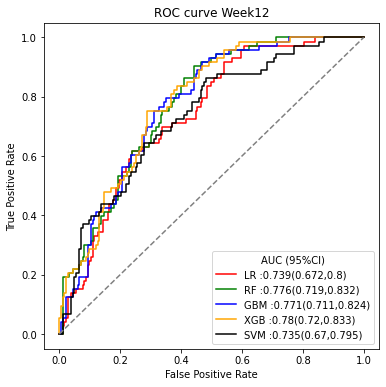

In [47]:
plot_roc_curve(fpers12, tpers12,week12_auc,12)

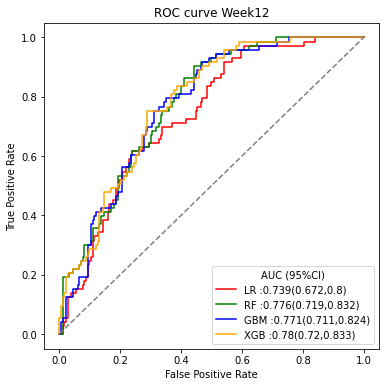

In [48]:
plot_roc_curve2(fpers12, tpers12,week12_auc,12)

### 3. SHAP value

Using 598 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/598 [00:00<?, ?it/s]

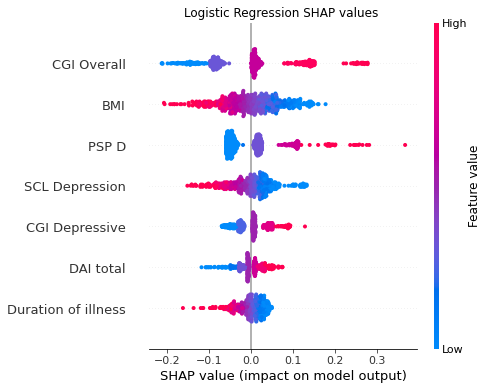

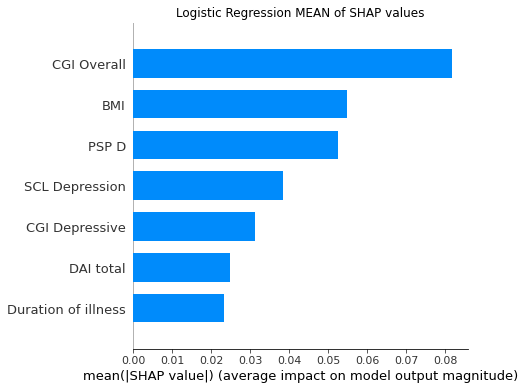

None


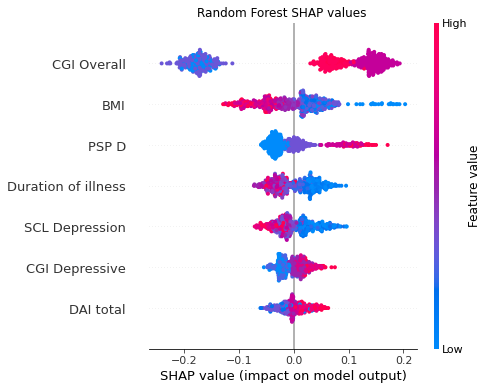

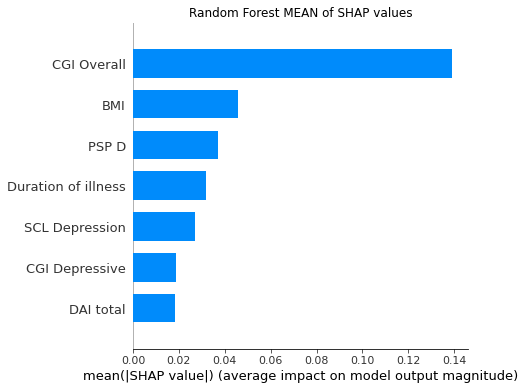

None


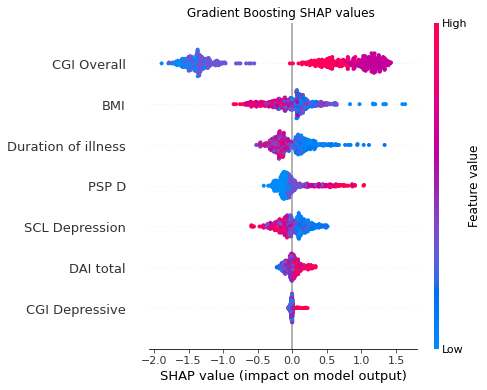

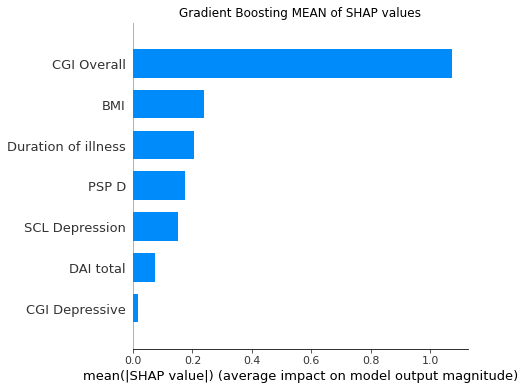

None


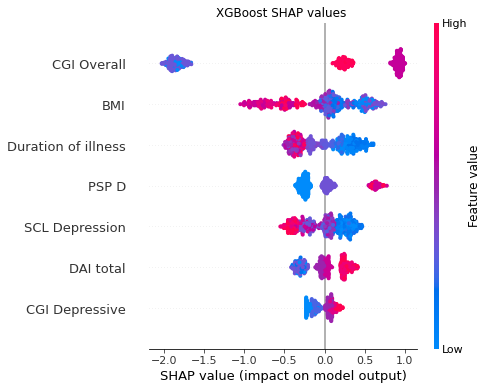

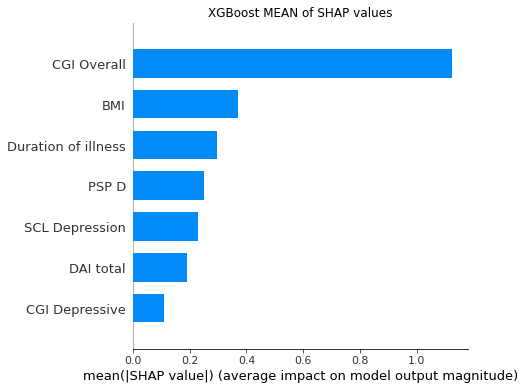

None


In [ ]:
print(show_shap('Logistic Regression', lr.predict_proba, X, is_tree=False,xgbm=False))
print(show_shap('Random Forest', rf, X, is_tree=True,xgbm=False))
print(show_shap('Gradient Boosting', gbm, X, is_tree=True,xgbm=True))
print(show_shap('XGBoost', xgb, X, is_tree=True,xgbm=True))

### 4. feature importance

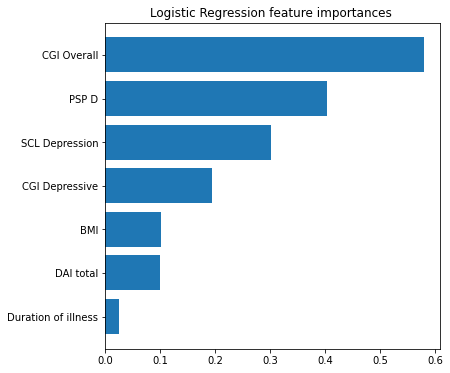

None


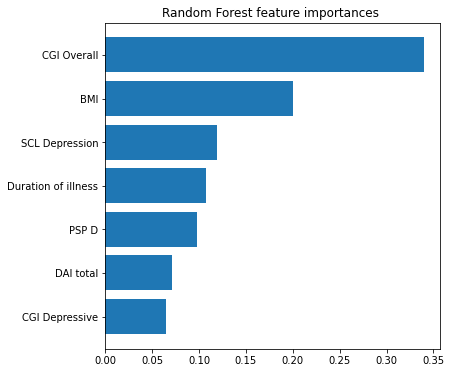

None


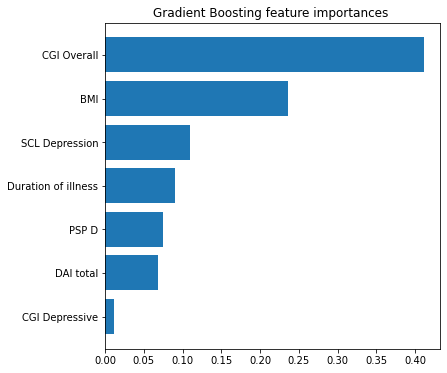

None


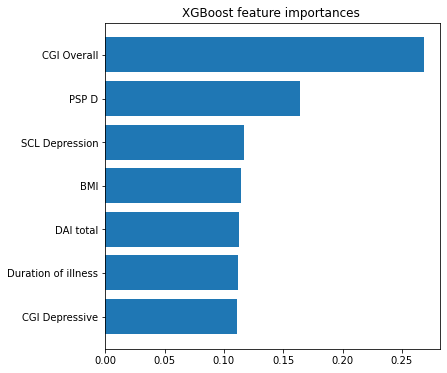

None


In [ ]:
features_names = dat_tra12.columns[1:]

print(feature_importances('Logistic Regression', abs(lr.coef_[0]), features_names))
print(feature_importances('Random Forest', rf.feature_importances_, features_names))
print(feature_importances('Gradient Boosting', gbm.feature_importances_, features_names))
print(feature_importances('XGBoost', xgb.feature_importances_, features_names))

# 16주차 모델링

## 사용 변수만 불러오기

In [49]:
# 16주차에 해당하는 변수만 가지고 오기
dat_tra16 =  dat_tra[['cgis_r_w16', 'scl_is_sum','bmi', 'PSPB_w0' ,'CGISCHSD_w0' , 
                    'w0_DAI_total', 'scl_anx_sum', 'CGISCHSC_w0', 
                    'PSPC_w0', 'PSPA_w0', 'duration_illness','sex' ,'educationFlag_w0']]

dat_tes16 =  dat_tes[['cgis_r_w16', 'scl_is_sum','bmi', 'PSPB_w0' ,'CGISCHSD_w0' , 
                    'w0_DAI_total', 'scl_anx_sum', 'CGISCHSC_w0', 
                    'PSPC_w0', 'PSPA_w0', 'duration_illness','sex' ,'educationFlag_w0']]

In [50]:
dat_tra16.rename(columns = name_dic,inplace=True)
dat_tes16.rename(columns = name_dic,inplace=True)

In [51]:
X = dat_tra16.drop(columns = 'cgis_r_w16') # 설명변수만
y = dat_tra16['cgis_r_w16'] # response varaible
X_test = dat_tes16.drop(columns='cgis_r_w16')
y_test = dat_tes16['cgis_r_w16']

## 모델링

In [ ]:
# lr
parameters = {'C':[0.001, 0.01, 0.1, 1]}

lr = LogisticRegression(penalty='none', random_state=2022)  
grid = GridSearchCV(lr, parameters, cv=5, scoring = 'roc_auc')
grid.fit(X, y)
lr = grid.best_estimator_
lr.fit(X, y)

LogisticRegression(C=0.001, penalty='none', random_state=2022)

In [ ]:
# rf
parameters = {'max_depth': [5, 7, 9, 11],
                'max_features': ['auto', 'sqrt'],
                'min_samples_leaf': [2, 3, 4, 5],
                'min_samples_split': [2, 4, 6, 8],
                'n_estimators': [100, 200, 500]}

rnd = RandomForestClassifier(random_state=2022)
grid = GridSearchCV(rnd, parameters, cv=5,scoring = 'roc_auc')
grid.fit(X, y)
rf = grid.best_estimator_
rf.fit(X, y)

RandomForestClassifier(max_depth=9, min_samples_leaf=3, n_estimators=500,
                       random_state=2022)

In [ ]:
# svc
parameters = {'C': [0.1, 1, 10],
                'gamma': [1, 0.1, 0.01, 0.001]}

svc = SVC(kernel='rbf', random_state=2022, probability=True)
grid = GridSearchCV(svc, parameters,cv=5,scoring = 'roc_auc')
grid.fit(X, y)
svc = grid.best_estimator_
svc.fit(X, y)

SVC(C=10, gamma=0.01, probability=True, random_state=2022)

In [ ]:
# gbm
parameters = {'max_depth': [5, 7 ,9, 11],
                'min_samples_leaf': [2, 3, 4, 5],
                'min_samples_split': [2, 4, 6],
                'n_estimators': [100, 200, 500],
                'learning_rate': [0.01, 0.05, 0.1]}

gbm = GradientBoostingClassifier(random_state=2022)
grid = GridSearchCV(gbm, parameters, cv=5,scoring = 'roc_auc')
grid.fit(X, y)
gbm = grid.best_estimator_
gbm.fit(X, y)

GradientBoostingClassifier(learning_rate=0.01, max_depth=7, min_samples_leaf=5,
                           n_estimators=500, random_state=2022)

In [ ]:
# xgb
parameters = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'max_depth': [5, 7, 9, 11],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8],
        'learning_rate' : [0.01, 0.1],
        'n_estimators' : [100, 200, 500]
        }

xgb = XGBClassifier(silent=True, nthread=1,random_state=2022)
grid = GridSearchCV(xgb, parameters, cv=5,scoring = 'roc_auc')
grid.fit(X, y)
xgb = grid.best_estimator_
xgb.fit(X, y)

XGBClassifier(colsample_bytree=0.6, gamma=2, max_depth=5, min_child_weight=10,
              n_estimators=200, nthread=1, random_state=2022, silent=True,
              subsample=0.6)

## 결과

### 1. AUC score (test data)

In [57]:
week16_auc = auc_table(y_test,X_test)
week16_auc

,model list,auc,lower,upper
0,logistic regression,0.682,0.616,0.744
1,random forest,0.711,0.649,0.773
2,gbm,0.692,0.626,0.756
3,xgboost,0.683,0.621,0.748
4,scv rbf,0.661,0.596,0.724


### 2. ROC curve (test data)

In [58]:
# fpr : False Positive Rate , tpr : True Positive Rate 
fpers16,tpers16= [],[] # 각 모델에서의  fpr,tpr을 동시에 저장 

lr_fpr16, lr_tpr16 , lr_thresholds16 = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
fpers16.append(lr_fpr16) ; tpers16.append(lr_tpr16)

rf_fpr16, rf_tpr16 , rf_thresholds16 = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
fpers16.append(rf_fpr16) ; tpers16.append(rf_tpr16)

gbm_fpr16, gbm_tpr16 , gbm_thresholds16 = roc_curve(y_test, gbm.predict_proba(X_test)[:,1])
fpers16.append(gbm_fpr16) ; tpers16.append(gbm_tpr16)

xgb_fpr16, xgb_tpr16 , xgb_thresholds16 = roc_curve(y_test, xgb.predict_proba(X_test)[:,1])
fpers16.append(xgb_fpr16) ; tpers16.append(xgb_tpr16)

svc_fpr16, svc_tpr16 , svc_thresholds16 = roc_curve(y_test, svc.predict_proba(X_test)[:,1])
fpers16.append(svc_fpr16) ; tpers16.append(svc_tpr16)

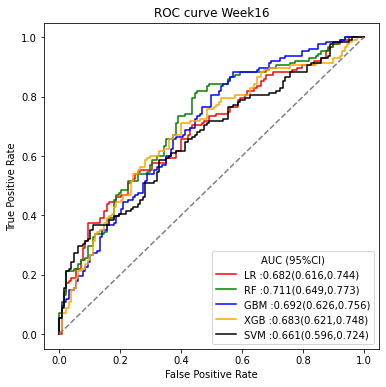

In [59]:
plot_roc_curve(fpers16, tpers16,week16_auc,16)

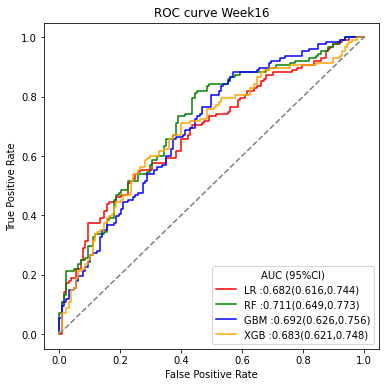

In [60]:
plot_roc_curve2(fpers16, tpers16,week16_auc,16)

### 3. SHAP value

Using 598 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/598 [00:00<?, ?it/s]

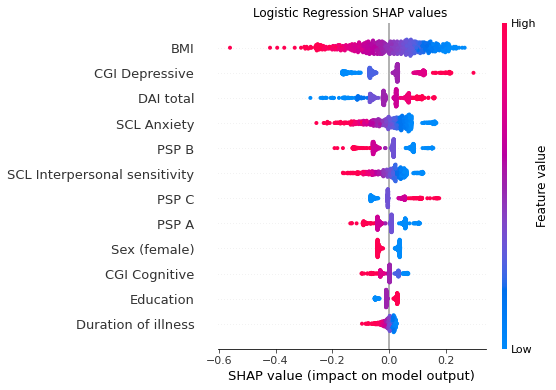

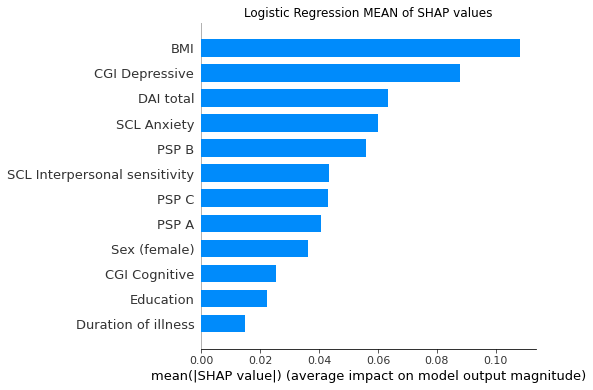

None


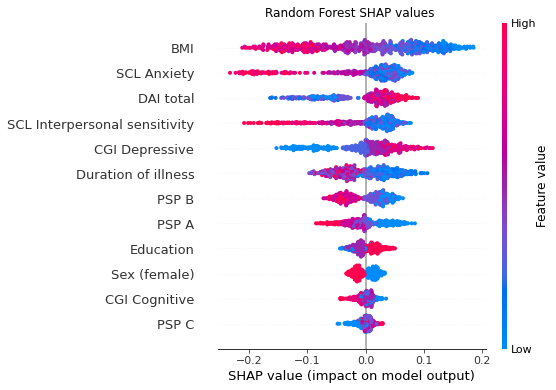

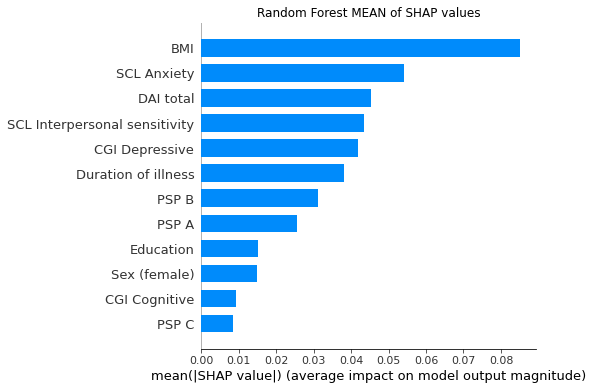

None


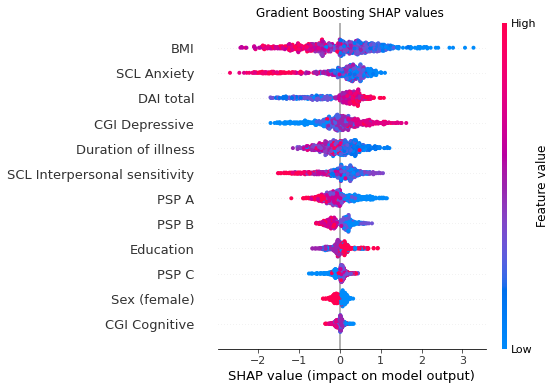

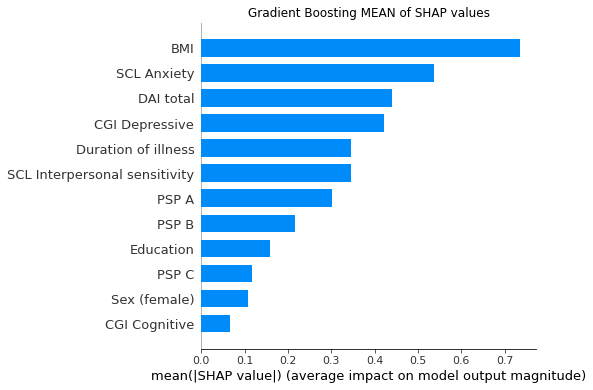

None


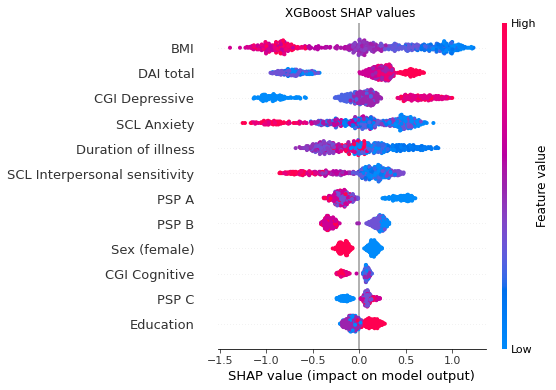

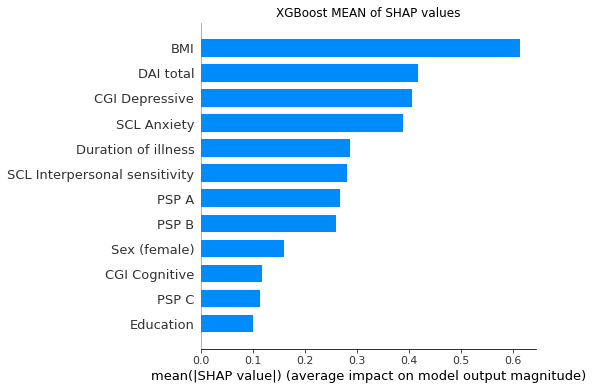

None


In [ ]:
print(show_shap('Logistic Regression', lr.predict_proba, X, is_tree=False,xgbm=False))
print(show_shap('Random Forest', rf, X, is_tree=True,xgbm=False))
print(show_shap('Gradient Boosting', gbm, X, is_tree=True,xgbm=True))
print(show_shap('XGBoost', xgb, X, is_tree=True,xgbm=True))

### 4. feature importance

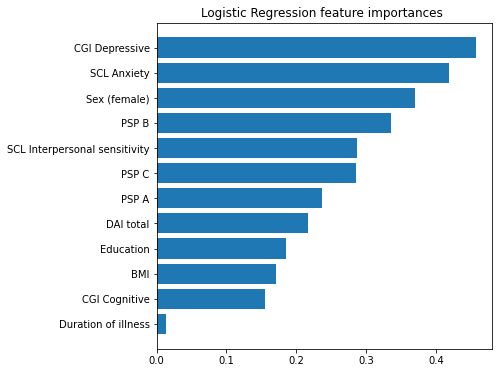

None


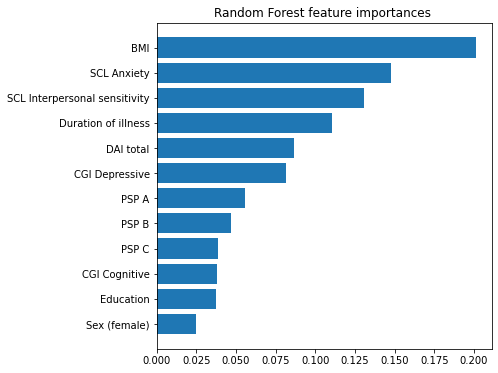

None


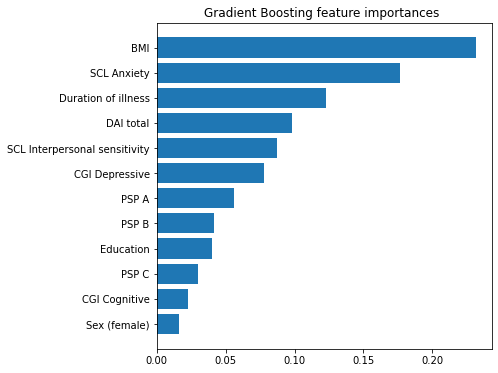

None


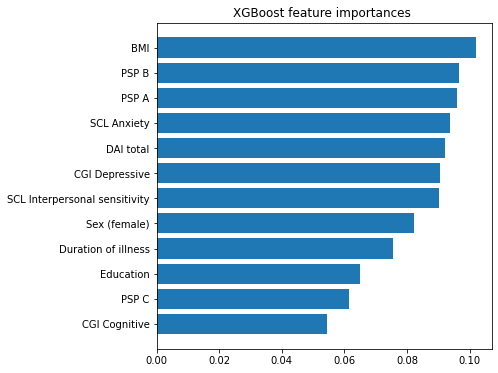

None


In [ ]:
features_names = dat_tra16.columns[1:]

print(feature_importances('Logistic Regression', abs(lr.coef_[0]), features_names))
print(feature_importances('Random Forest', rf.feature_importances_, features_names))
print(feature_importances('Gradient Boosting', gbm.feature_importances_, features_names))
print(feature_importances('XGBoost', xgb.feature_importances_, features_names))

# 24주차 모델링

## 사용 변수만 불러오기

In [89]:
# 24주차에 해당하는 변수만 가지고 오기
dat_tra24 =  dat_tra[['cgis_r_w24', 'scl_psy_sum','CGISCHSO_w0', 'scl_is_sum' ,'CGISCHSD_w0' , 
                    'PSPA_w0', 'bmi', 'scl_dep_sum', 
                    'w0_DAI_total', 'CGISCHSN_w0', 'PSPC_w0', 'scl_phob_sum','scl_som_sum']]

dat_tes24 =  dat_tes[['cgis_r_w24', 'scl_psy_sum','CGISCHSO_w0', 'scl_is_sum' ,'CGISCHSD_w0' , 
                    'PSPA_w0', 'bmi', 'scl_dep_sum', 
                    'w0_DAI_total', 'CGISCHSN_w0', 'PSPC_w0', 'scl_phob_sum','scl_som_sum']]

In [90]:
dat_tra24.rename(columns = name_dic,inplace=True)
dat_tes24.rename(columns = name_dic,inplace=True)

In [91]:
X = dat_tra24.drop(columns = 'cgis_r_w24') # 설명변수만
y = dat_tra24['cgis_r_w24'] # response varaible
X_test = dat_tes24.drop(columns='cgis_r_w24')
y_test = dat_tes24['cgis_r_w24']

## 모델링

In [ ]:
# lr
parameters = {'C':[0.001, 0.01, 0.1, 1]}

lr = LogisticRegression(penalty='none', random_state=2022)  
grid = GridSearchCV(lr, parameters, cv=5, scoring = 'roc_auc')
grid.fit(X, y)
lr = grid.best_estimator_
lr.fit(X, y)

LogisticRegression(C=0.001, penalty='none', random_state=2022)

In [ ]:
# rf
parameters = {'max_depth': [5, 7, 9, 11],
                'max_features': ['auto', 'sqrt'],
                'min_samples_leaf': [2, 3, 4, 5],
                'min_samples_split': [2, 4, 6, 8],
                'n_estimators': [100, 200, 500]}

rnd = RandomForestClassifier(random_state=2022)
grid = GridSearchCV(rnd, parameters, cv=5,scoring = 'roc_auc')
grid.fit(X, y)
rf = grid.best_estimator_
rf.fit(X, y)

RandomForestClassifier(max_depth=11, min_samples_leaf=4, n_estimators=500,
                       random_state=2022)

In [ ]:
# svc
parameters = {'C': [0.1, 1, 10],
                'gamma': [1, 0.1, 0.01, 0.001]}

svc = SVC(kernel='rbf', random_state=2022, probability=True)
grid = GridSearchCV(svc, parameters,cv=5,scoring = 'roc_auc')
grid.fit(X, y)
svc = grid.best_estimator_
svc.fit(X, y)

SVC(C=10, gamma=0.001, probability=True, random_state=2022)

In [ ]:
# gbm
parameters = {'max_depth': [5, 7 ,9, 11],
                'min_samples_leaf': [2, 3, 4, 5],
                'min_samples_split': [2, 4, 6],
                'n_estimators': [100, 200, 500],
                'learning_rate': [0.01, 0.05, 0.1]}

gbm = GradientBoostingClassifier(random_state=2022)
grid = GridSearchCV(gbm, parameters, cv=5,scoring = 'roc_auc')
grid.fit(X, y)
gbm = grid.best_estimator_
gbm.fit(X, y)

GradientBoostingClassifier(learning_rate=0.01, max_depth=5, min_samples_leaf=5,
                           n_estimators=500, random_state=2022)

In [ ]:
# xgb
parameters = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'max_depth': [5, 7, 9, 11],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8],
        'learning_rate' : [0.01, 0.1],
        'n_estimators' : [100, 200, 500]
        }

xgb = XGBClassifier(silent=True, nthread=1,random_state=2022)
grid = GridSearchCV(xgb, parameters, cv=5,scoring = 'roc_auc')
grid.fit(X, y)
xgb = grid.best_estimator_
xgb.fit(X, y)

XGBClassifier(colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=9,
              min_child_weight=5, n_estimators=500, nthread=1,
              random_state=2022, silent=True, subsample=1.0)

XGBClassifier(colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=9,
              min_child_weight=5, n_estimators=500, nthread=1,
              random_state=2022, silent=True, subsample=1.0)

## 결과

### 1. AUC score (test data)

In [69]:
week24_auc = auc_table(y_test,X_test)
week24_auc

,model list,auc,lower,upper
0,logistic regression,0.84,0.787,0.887
1,random forest,0.829,0.778,0.877
2,gbm,0.806,0.75,0.857
3,xgboost,0.83,0.773,0.879
4,scv rbf,0.828,0.773,0.88


### 2. ROC curve (test data)

In [70]:
# fpr : False Positive Rate , tpr : True Positive Rate 
fpers24,tpers24= [],[] # 각 모델에서의  fpr,tpr을 동시에 저장 

lr_fpr24, lr_tpr24 , lr_thresholds24 = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
fpers24.append(lr_fpr24) ; tpers24.append(lr_tpr24)

rf_fpr24, rf_tpr24 , rf_thresholds24 = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
fpers24.append(rf_fpr24) ; tpers24.append(rf_tpr24)

gbm_fpr24, gbm_tpr24 , gbm_thresholds24 = roc_curve(y_test, gbm.predict_proba(X_test)[:,1])
fpers24.append(gbm_fpr24) ; tpers24.append(gbm_tpr24)

xgb_fpr24, xgb_tpr24, xgb_thresholds24 = roc_curve(y_test, xgb.predict_proba(X_test)[:,1])
fpers24.append(xgb_fpr24) ; tpers24.append(xgb_tpr24)

svc_fpr24, svc_tpr24 , svc_thresholds24 = roc_curve(y_test, svc.predict_proba(X_test)[:,1])
fpers24.append(svc_fpr24) ; tpers24.append(svc_tpr24)

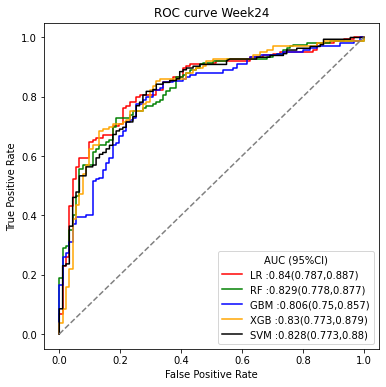

In [71]:
plot_roc_curve(fpers24, tpers24,week24_auc,24)

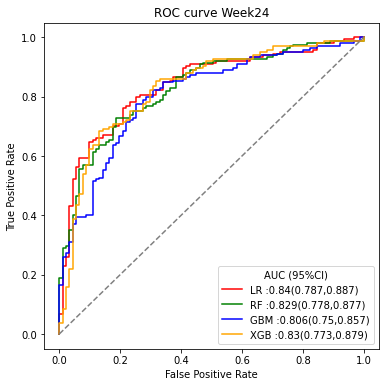

In [72]:
plot_roc_curve2(fpers24, tpers24,week24_auc,24)

### 3. SHAP value

Using 598 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/598 [00:00<?, ?it/s]

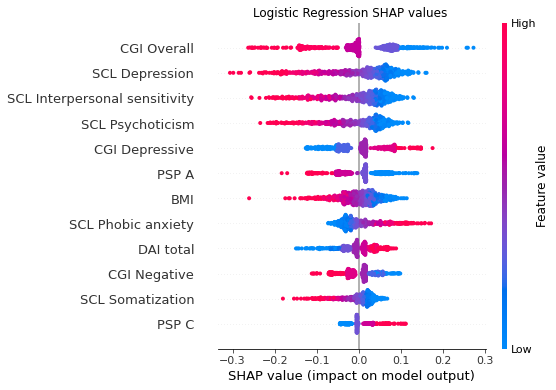

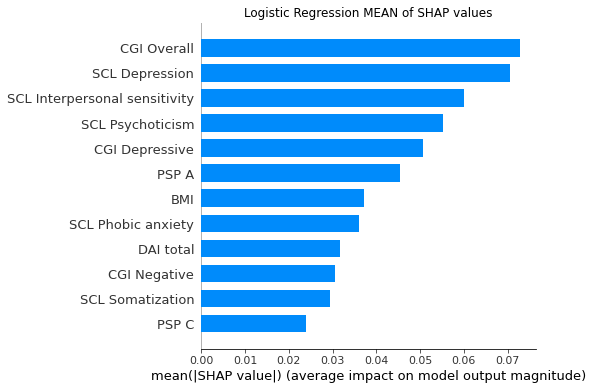

None


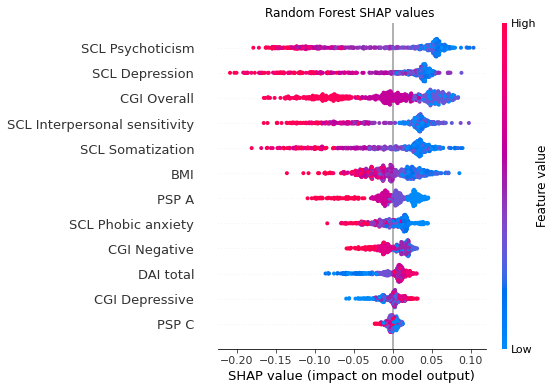

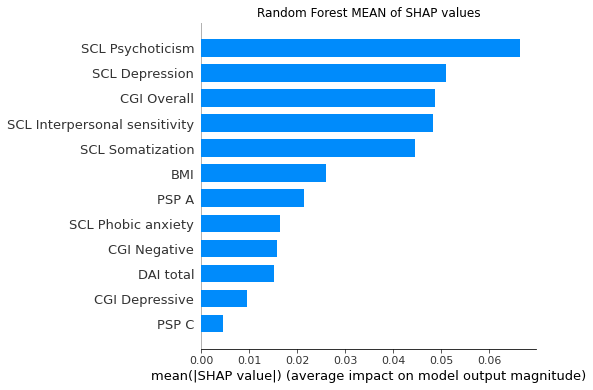

None


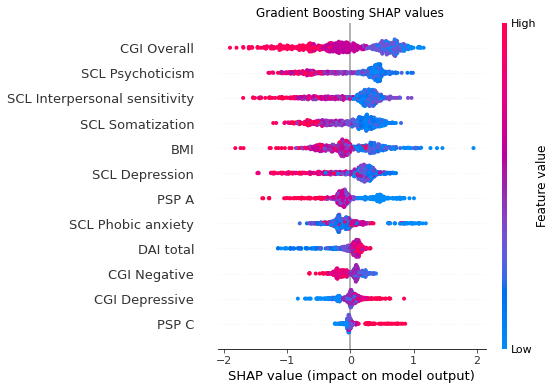

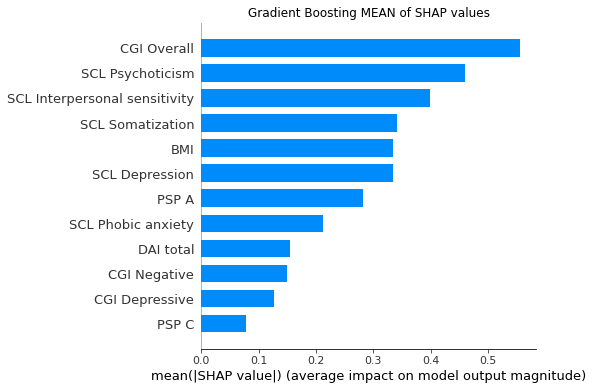

None


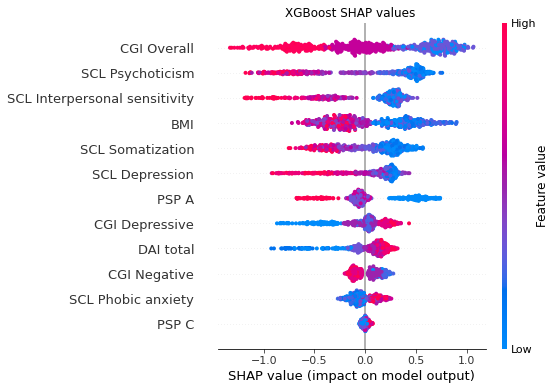

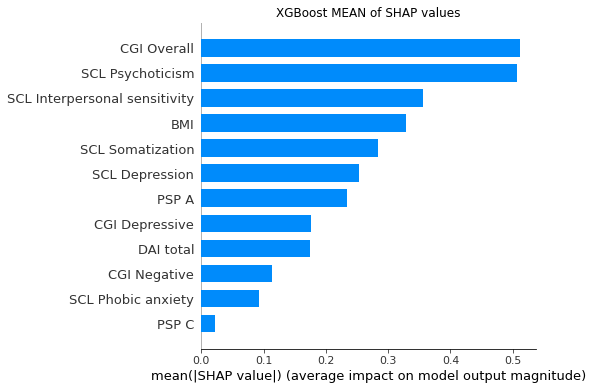

None


In [ ]:
print(show_shap('Logistic Regression', lr.predict_proba, X, is_tree=False,xgbm=False))
print(show_shap('Random Forest', rf, X, is_tree=True,xgbm=False))
print(show_shap('Gradient Boosting', gbm, X, is_tree=True,xgbm=True))
print(show_shap('XGBoost', xgb, X, is_tree=True,xgbm=True))

### 4. feature importance

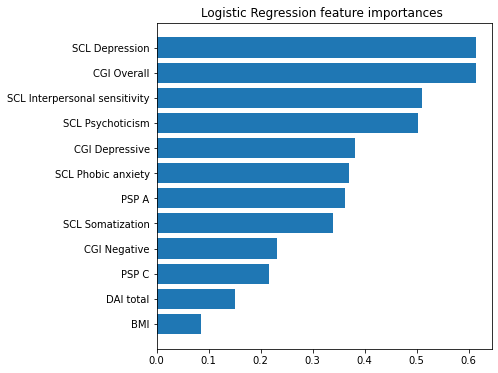

None


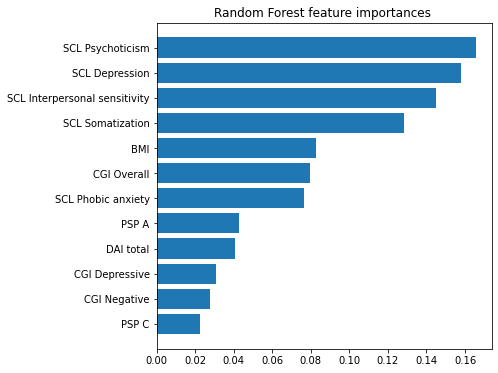

None


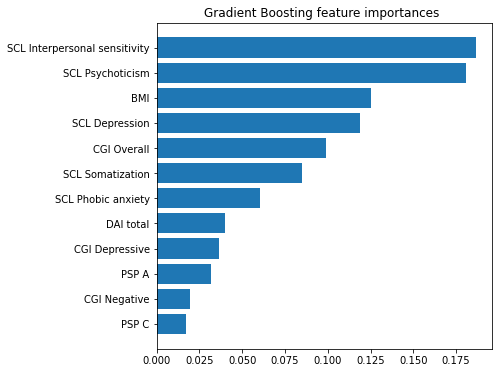

None


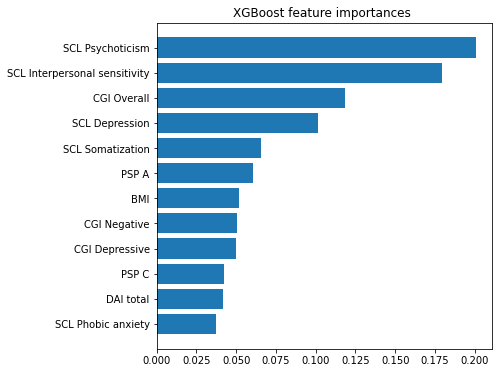

None


In [ ]:
features_names = dat_tra24.columns[1:]

print(feature_importances('Logistic Regression', abs(lr.coef_[0]), features_names))
print(feature_importances('Random Forest', rf.feature_importances_, features_names))
print(feature_importances('Gradient Boosting', gbm.feature_importances_, features_names))
print(feature_importances('XGBoost', xgb.feature_importances_, features_names))